In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import re

pd.set_option('max_columns', 500)

# For plotting
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

OptionError: Pattern matched multiple keys

In [3]:
tweets = pd.read_csv('tweets.csv')

In [4]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

In [4]:
tweets['tweet_date'].value_counts() \
    .plot(figsize=(10, 5), title='Wordle Tweets by Day',
          color=color_pal[2], lw=5)
plt.show()

NameError: name 'tweets' is not defined

In [6]:
tweets.groupby('wordle_id')['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient(axis=1)

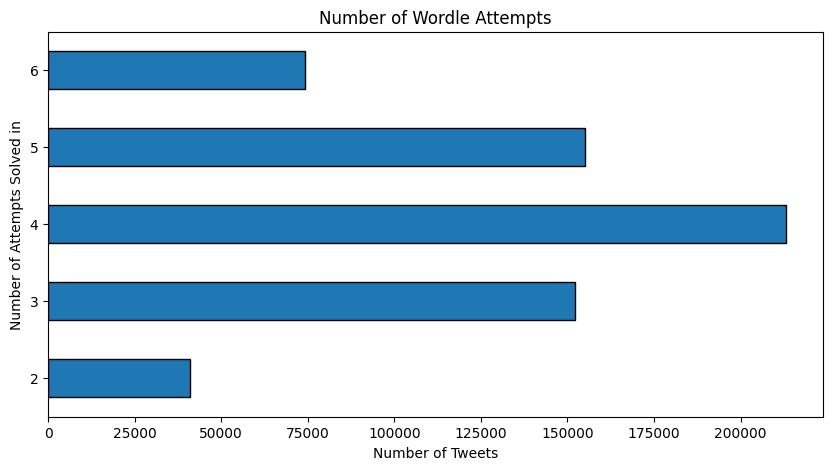

In [7]:
ax = tweets['n_attempts'].value_counts() \
    .sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()


In [8]:
# Make dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [9]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

In [10]:
# Keep additional tweet text
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

In [ ]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black', color=color_pal[5])
plt.show()